# Example Jupyter notebook to work with the data

# Read in and plot the Apollo 12 Grade A catalog

In [15]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# For comparison metrics
from sklearn.metrics import mean_squared_error

import torch


In [4]:
!pip install pandas obspy matplotlib scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.7/163.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 17.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 620.3 kB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 37.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 19.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 18.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.0/508.0 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.5 MB/s eta 0:00:00

# Read CSV & Preprocess 

In [6]:

# Load the files
file_paths = {
    'VBB_Velocity': 'xb.elyse.02.bhu.2022/001/xb.elyse.02.bhu.2022.001.8.a.csv', # 20HZ
    'VBB_Temperature': 'xb.elyse.02.bhu.2022/001/xb.elyse.03.vku.2022.001.5.a.csv', #0.1HZ
    'VBB_Pos': 'xb.elyse.02.bhu.2022/001/xb.elyse.05.vmu.2022.001.7.a.csv', #0.5HZ
    'SP_Velocity': 'xb.elyse.02.bhu.2022/001/xb.elyse.68.shu.2022.001.7.a.csv' #10HZ
}

# Re-read the files by using 'comment' to drop rows starting with '#'
data_cleaned = {name: pd.read_csv(path, names = ['Time', name], delimiter=',', comment='#') for name, path in file_paths.items()}

for i in data_cleaned.keys():
    data_cleaned[i] = data_cleaned[i][1:]

/tmp/ipykernel_574/4115464708.py:12: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data_cleaned = {name: pd.read_csv(path, names = ['Time', name], delimiter=',', comment='#') for name, path in file_paths.items()}
/tmp/ipykernel_574/4115464708.py:12: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data_cleaned = {name: pd.read_csv(path, names = ['Time', name], delimiter=',', comment='#') for name, path in file_paths.items()}


## Down-Sampling & UP-Sampling

In [186]:
def insert_nan_rows(df, num_nan):
    # Calculate the new length after inserting NaN rows
    n_rows = len(df)
    total_new_rows = n_rows + (n_rows * num_nan)
    
    # Create an empty DataFrame with NaN values of the desired size
    expanded_df = pd.DataFrame(np.nan, index=np.arange(total_new_rows), columns=df.columns)
    
    # Insert the original rows in their new positions
    expanded_df.iloc[::num_nan + 1] = df.values
    
    return expanded_df

In [187]:
# Make All the data of 2HZ

#Down Sample
data_cleaned['VBB_Velocity'] = data_cleaned['VBB_Velocity'].iloc[::10,:].reset_index(drop=True)
data_cleaned['SP_Velocity'] = data_cleaned['SP_Velocity'].iloc[::5,:].reset_index(drop=True)

# Up Sample
data_cleaned['VBB_Pos'] = insert_nan_rows(data_cleaned['VBB_Pos'], 3)

data_cleaned['VBB_Temperature'] = insert_nan_rows(data_cleaned['VBB_Temperature'], 19)


In [189]:
data_cleaned['SP_Velocity'].drop('Time', axis=1, inplace=True)
data_cleaned['VBB_Pos'].drop('Time', axis=1, inplace=True)
data_cleaned['VBB_Temperature'].drop('Time', axis=1, inplace=True)

print(data_cleaned['SP_Velocity'].shape)
print(data_cleaned['VBB_Pos'].shape)
print(data_cleaned['VBB_Temperature'].shape)

(172800, 1)
(172800, 1)
(172800, 1)


In [190]:
fullData = pd.DataFrame()
for k in data_cleaned.keys():
    fullData = pd.concat([fullData, data_cleaned[k]], axis=1)
fullData

,Time,VBB_Velocity,VBB_Temperature,VBB_Pos,SP_Velocity
0,2022-01-01T00:00:00.012000Z,5026,41896,2648447,86492
1,2022-01-01T00:00:00.512000Z,4637,NaN,NaN,86464
2,2022-01-01T00:00:01.012000Z,5049,NaN,NaN,86469
3,2022-01-01T00:00:01.512000Z,4907,NaN,NaN,86538
4,2022-01-01T00:00:02.012000Z,4736,NaN,2648939,86572
...,...,...,...,...,...
172795,2022-01-01T23:59:57.512000Z,6706,NaN,NaN,86965
172796,2022-01-01T23:59:58.012000Z,7051,NaN,2012098,86929
172797,2022-01-01T23:59:58.512000Z,6130,NaN,NaN,86826
172798,2022-01-01T23:59:59.012000Z,5526,NaN,NaN,86865


In [191]:
fullData = fullData.ffill().bfill()

In [17]:
fullData.to_csv('fullData.csv', index=False)

In [16]:
fullData = pd.read_csv("fullData.csv")

fullData['Time'] = pd.to_datetime(fullData['Time'])
fullData.set_index('Time', inplace=True)

fullData

,VBB_Velocity,VBB_Temperature,VBB_Pos,SP_Velocity
Time,,,,
2022-01-01 00:00:00.012000+00:00,5026,41896,2648447,86492
2022-01-01 00:00:00.512000+00:00,4637,41896,2648447,86464
2022-01-01 00:00:01.012000+00:00,5049,41896,2648447,86469
2022-01-01 00:00:01.512000+00:00,4907,41896,2648447,86538
2022-01-01 00:00:02.012000+00:00,4736,41896,2648939,86572
...,...,...,...,...
2022-01-01 23:59:57.512000+00:00,6706,41490,2011545,86965
2022-01-01 23:59:58.012000+00:00,7051,41490,2012098,86929
2022-01-01 23:59:58.512000+00:00,6130,41490,2012098,86826


# Standard Scaler

In [24]:
from sklearn.preprocessing import StandardScaler

# Assuming TrainData is a Pandas DataFrame
scaler = StandardScaler()

# Fit the scaler to the data and transform it
TrainData_scaled = scaler.fit_transform(TrainData)

# If you want to convert the scaled data back into a DataFrame with the original column names
TrainData_scaled = pd.DataFrame(TrainData_scaled, columns=TrainData.columns, index=TrainData.index)


# Zscore

In [21]:
# Z-score calculation for anomaly detection
z_scores = (TrainData_scaled - TrainData_scaled.mean()) / TrainData_scaled.std()
anomalies = z_scores[(z_scores.abs() > 3).any(axis=1)]

# Save the anomalies data into a CSV file
anomalies.to_csv('seismic_anomalies2.csv')

print("Anomalies saved to 'seismic_anomalies.csv'")

Anomalies saved to 'seismic_anomalies.csv'


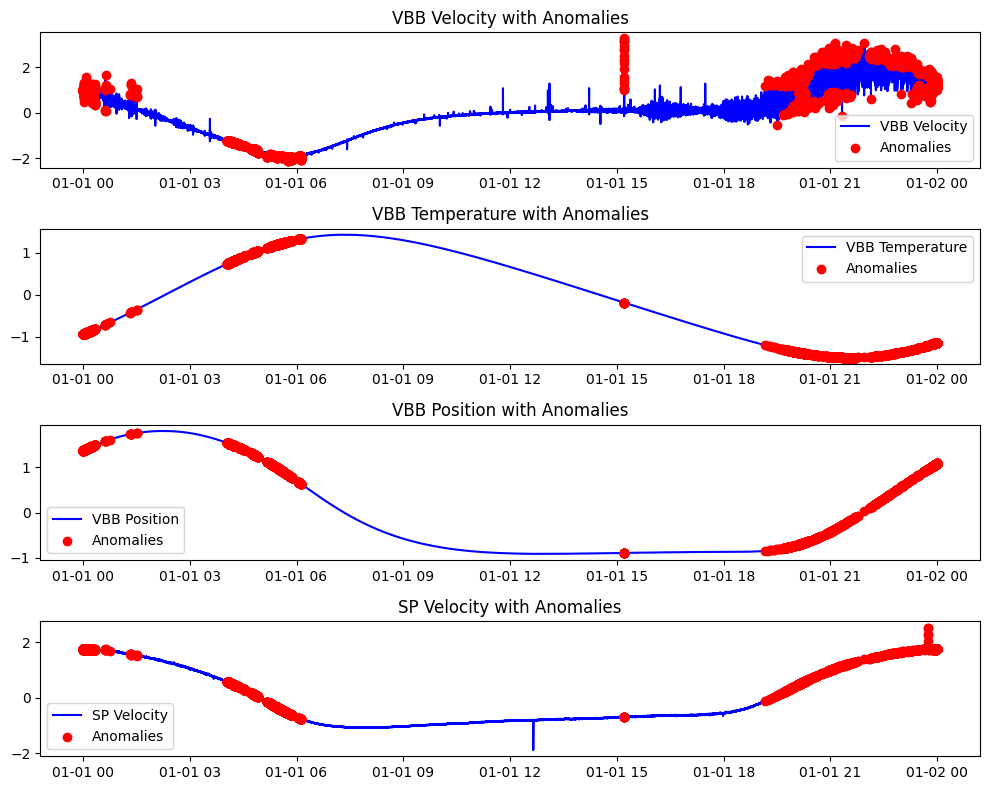

In [23]:
# Plot the seismic data with anomalies highlighted
plt.figure(figsize=(10, 8))

# Plot the VBB Velocity signal
plt.subplot(4, 1, 1)
plt.plot(TrainData_scaled.index, TrainData_scaled['VBB_Velocity'], label='VBB Velocity', color='blue')
plt.scatter(anomalies.index, anomalies['VBB_Velocity'], color='red', label='Anomalies', zorder=5)
plt.title('VBB Velocity with Anomalies')
plt.legend()

# Plot the VBB Temperature signal
plt.subplot(4, 1, 2)
plt.plot(TrainData_scaled.index, TrainData_scaled['VBB_Temperature'], label='VBB Temperature', color='blue')
plt.scatter(anomalies.index, anomalies['VBB_Temperature'], color='red', label='Anomalies', zorder=5)
plt.title('VBB Temperature with Anomalies')
plt.legend()

# Plot the VBB Position signal
plt.subplot(4, 1, 3)
plt.plot(TrainData_scaled.index, TrainData_scaled['VBB_Pos'], label='VBB Position', color='blue')
plt.scatter(anomalies.index, anomalies['VBB_Pos'], color='red', label='Anomalies', zorder=5)
plt.title('VBB Position with Anomalies')
plt.legend()

# Plot the SP Velocity signal
plt.subplot(4, 1, 4)
plt.plot(TrainData_scaled.index, TrainData_scaled['SP_Velocity'], label='SP Velocity', color='blue')
plt.scatter(anomalies.index, anomalies['SP_Velocity'], color='red', label='Anomalies', zorder=5)
plt.title('SP Velocity with Anomalies')
plt.legend()

plt.tight_layout()
plt.show()


# IsolationForest

In [25]:
# Use the IsolationForest for anomaly detection
model = IsolationForest(contamination=0.05)  # adjust contamination rate for sensitivity
model.fit(TrainData_scaled)

# Predict anomalies (-1 indicates an anomaly)
TrainData_scaled['anomaly'] = model.predict(TrainData_scaled)

# Extract the anomalies
anomalies = TrainData_scaled[TrainData_scaled['anomaly'] == -1]

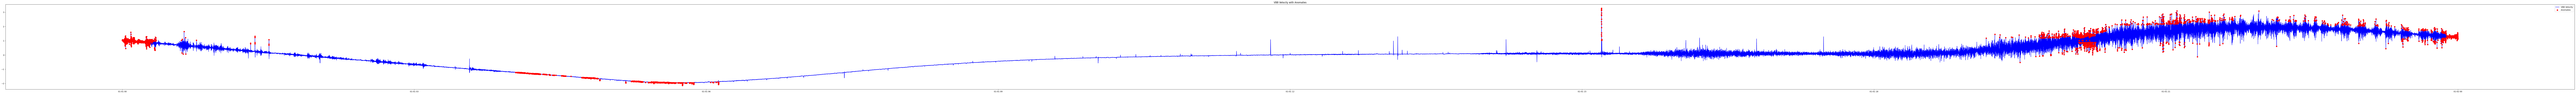

In [26]:
plt.figure(figsize=(240, 8))
plt.plot(TrainData_scaled.index, TrainData_scaled['VBB_Velocity'], label='VBB Velocity', color='blue')
plt.scatter(anomalies.index, anomalies['VBB_Velocity'], color='red', label='Anomalies', zorder=5)
plt.title('VBB Velocity with Anomalies')
plt.legend()

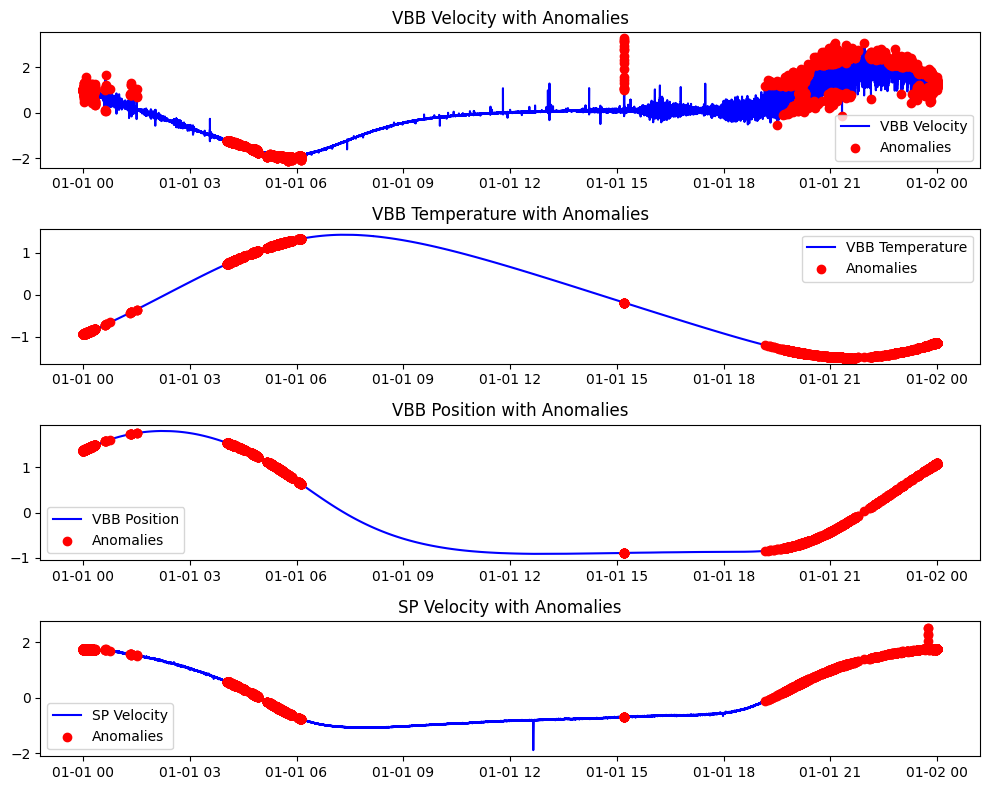

In [27]:
import matplotlib.pyplot as plt

# Plot the seismic data with anomalies highlighted
plt.figure(figsize=(10, 8))

# Plot the VBB Velocity signal
plt.subplot(4, 1, 1)
plt.plot(TrainData_scaled.index, TrainData_scaled['VBB_Velocity'], label='VBB Velocity', color='blue')
plt.scatter(anomalies.index, anomalies['VBB_Velocity'], color='red', label='Anomalies', zorder=5)
plt.title('VBB Velocity with Anomalies')
plt.legend()

# Plot the VBB Temperature signal
plt.subplot(4, 1, 2)
plt.plot(TrainData_scaled.index, TrainData_scaled['VBB_Temperature'], label='VBB Temperature', color='blue')
plt.scatter(anomalies.index, anomalies['VBB_Temperature'], color='red', label='Anomalies', zorder=5)
plt.title('VBB Temperature with Anomalies')
plt.legend()

# Plot the VBB Position signal
plt.subplot(4, 1, 3)
plt.plot(TrainData_scaled.index, TrainData_scaled['VBB_Pos'], label='VBB Position', color='blue')
plt.scatter(anomalies.index, anomalies['VBB_Pos'], color='red', label='Anomalies', zorder=5)
plt.title('VBB Position with Anomalies')
plt.legend()

# Plot the SP Velocity signal
plt.subplot(4, 1, 4)
plt.plot(TrainData_scaled.index, TrainData_scaled['SP_Velocity'], label='SP Velocity', color='blue')
plt.scatter(anomalies.index, anomalies['SP_Velocity'], color='red', label='Anomalies', zorder=5)
plt.title('SP Velocity with Anomalies')
plt.legend()

plt.tight_layout()
plt.show()


# Train-test split

In [28]:
train_size = int(len(fullData) * 0.8)
train, test = fullData[:train_size], fullData[train_size:]

# ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 500ms will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 500ms will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 500ms will be used.
  self._init_dates(dates, freq)


ARIMA MSE: 98666936.8885024


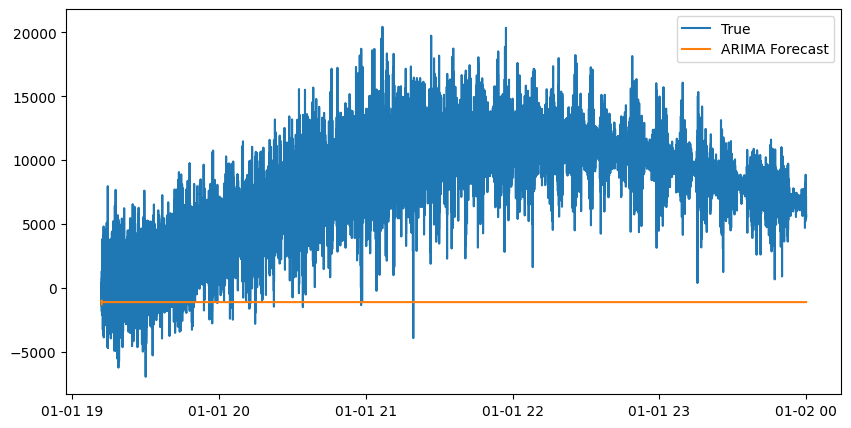

In [29]:
# Ensure you're only passing one column to the ARIMA/SARIMAX model
train_univariate = train['VBB_Velocity']  # Use only one time series column
test_univariate = test['VBB_Velocity']

# Fit ARIMA model (adjust the order if needed)
arima_model = ARIMA(train_univariate, order=(5, 1, 0))
arima_result = arima_model.fit()

# Forecast
arima_forecast = arima_result.forecast(steps=len(test_univariate))

# Calculate MSE
arima_mse = mean_squared_error(test_univariate, arima_forecast)
print(f'ARIMA MSE: {arima_mse}')

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(test_univariate.index, test_univariate, label='True')
plt.plot(test_univariate.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.show()


# SARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 500ms will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 500ms will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62256D+00    |proj g|=  8.47257D-02

At iterate    5    f=  7.56107D+00    |proj g|=  1.50329D-02

At iterate   10    f=  7.55433D+00    |proj g|=  5.34254D-03

At iterate   15    f=  7.55255D+00    |proj g|=  4.44611D-03

At iterate   20    f=  7.44317D+00    |proj g|=  3.55672D-02

At iterate   25    f=  7.44157D+00    |proj g|=  2.26058D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     30      1     0     0   

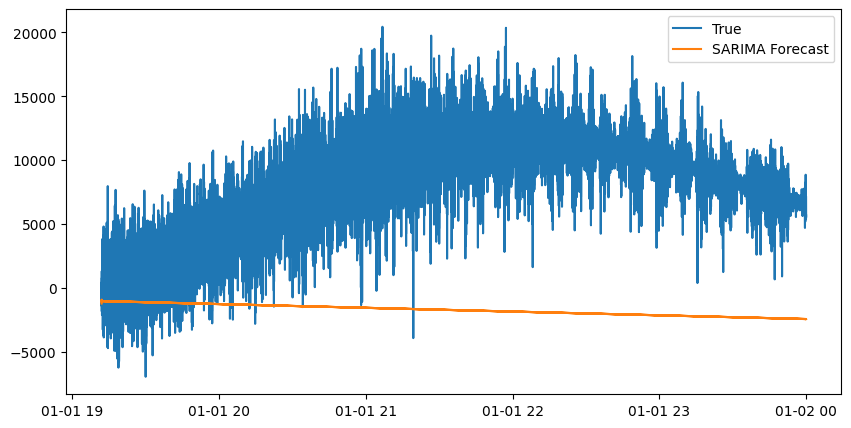

In [30]:
train_univariate = train['VBB_Velocity']  # Use only one time series column
test_univariate = test['VBB_Velocity']
# Fit SARIMA model
sarima_model = SARIMAX(train_univariate, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))  # Adjust seasonal_order as needed
sarima_result = sarima_model.fit()

# Forecast
sarima_forecast = sarima_result.forecast(steps=len(test_univariate))

# Calculate MSE
sarima_mse = mean_squared_error(test_univariate, sarima_forecast)
print(f'SARIMA MSE: {sarima_mse}')

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(test_univariate.index, test_univariate, label='True')
plt.plot(test_univariate.index, sarima_forecast, label='SARIMA Forecast')
plt.legend()
plt.show()


# SARIMAX

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 500ms will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 500ms will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.63271D+00    |proj g|=  7.66760D-02


 This problem is unconstrained.



At iterate    5    f=  7.57156D+00    |proj g|=  1.79336D-02

At iterate   10    f=  7.55371D+00    |proj g|=  1.64798D-02

At iterate   15    f=  7.55324D+00    |proj g|=  2.19092D-03

At iterate   20    f=  7.54939D+00    |proj g|=  3.64229D-02

At iterate   25    f=  7.47384D+00    |proj g|=  7.46419D-02

At iterate   30    f=  7.44225D+00    |proj g|=  3.18147D-03

At iterate   35    f=  7.44163D+00    |proj g|=  6.68987D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     43      1     0     0   3.271D-05   7.442D+00
  F =   7.4415541003536498     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

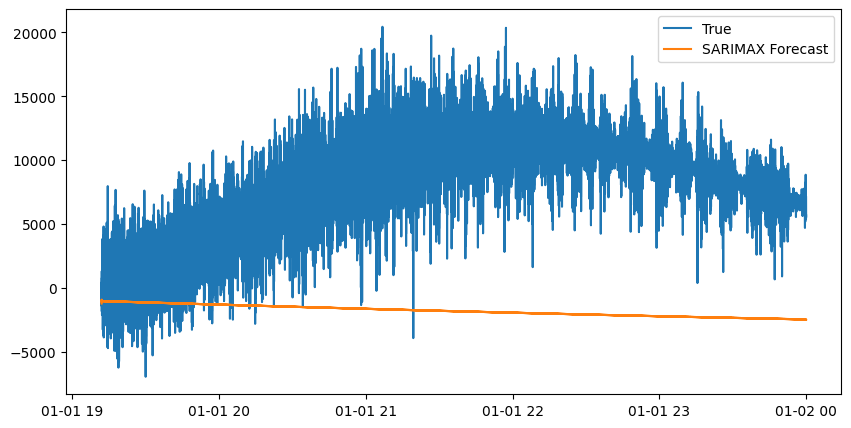

In [31]:
# Use only one column from the dataset for 'endog'
train_univariate = train['VBB_Velocity']  # Or choose another column
test_univariate = test['VBB_Velocity']

# Example using VBB_Temperature as an exogenous variable (can be multivariate)
exog_train = fullData[['VBB_Temperature']][:train_size]  # Wrap in double brackets to keep DataFrame format
exog_test = fullData[['VBB_Temperature']][train_size:]

# Fit SARIMAX model with univariate 'endog' and exogenous variable
sarimax_model = SARIMAX(train_univariate, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12), exog=exog_train)
sarimax_result = sarimax_model.fit()

# Forecast with exogenous variables
sarimax_forecast = sarimax_result.forecast(steps=len(test_univariate), exog=exog_test)

# Calculate MSE
sarimax_mse = mean_squared_error(test_univariate, sarimax_forecast)
print(f'SARIMAX MSE: {sarimax_mse}')

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(test_univariate.index, test_univariate, label='True')
plt.plot(test_univariate.index, sarimax_forecast, label='SARIMAX Forecast')
plt.legend()
plt.show()


# Calculate forecast errors

In [ ]:
# Calculate forecast errors
arima_errors = test - arima_forecast
sarima_errors = test - sarima_forecast
# sarimax_errors = test - sarimax_forecast

# Set threshold for anomaly detection
threshold = 2 * np.std(arima_errors)

# Detect anomalies where the error exceeds the threshold
arima_anomalies = test[np.abs(arima_errors) > threshold]
sarima_anomalies = test[np.abs(sarima_errors) > threshold]
# sarimax_anomalies = test[np.abs(sarimax_errors) > threshold]

# Plot anomalies
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='True')
plt.scatter(arima_anomalies.index, arima_anomalies, color='red', label='ARIMA Anomalies')
plt.legend()
plt.show()


# Optimized STA/LTA 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy.signal.trigger import classic_sta_lta, trigger_onset
new_df = pd.read_csv("../space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-04-25HR00_evid00006.csv", names=["Time", 'time_rel', 'VBB_Velocity'])[1:]
# new_df = new_df.rename(columns={new_df.keys()[0] : "Time", new_df.keys()[0]:new_df.keys()[0], "velocity(m/s)": "VBB_Velocity"})


print(new_df.keys())
new_df["VBB_Velocity"] = new_df["VBB_Velocity"].astype(float)
# Assuming 'new_df' contains 'Time' and 'VBB_Velocity' columns
# Convert 'Time' column to datetime format if it's not already
new_df['Time'] = pd.to_datetime(new_df['Time'])

# Set 'Time' as the index for convenience
new_df.set_index('Time', inplace=True)

# Convert the pandas DataFrame index (datetime) into a numeric time array (seconds from start)
new_df['time_in_seconds'] = (new_df.index - new_df.index[0]).total_seconds()

# Extract velocity data and time in seconds
tr_data = new_df['VBB_Velocity'].values
tr_times = new_df['time_in_seconds'].values
    
# Divide the velocity data by the given factor
division_factor = 8.62622E10
tr_data_divided = tr_data 

# Define the sampling rate (samples per second), based on the time difference between rows
df_sampling_rate = 1 / (new_df.index[1] - new_df.index[0]).total_seconds()

In [ ]:
# STA/LTA parameters
sta_len = 300  # Increase STA to 60 seconds to smooth rapid fluctuations
lta_len = 1200  # Increase LTA to 180 seconds to capture longer-lasting events
PEM = 30  # Extend event window by 30 seconds before the event starts
PET = 1000  # Extend event window by 60 seconds after the event ends
# Calculate the characteristic function (STA/LTA ratio) for the smoothed data
cft = classic_sta_lta(tr_data_divided, int(sta_len * df_sampling_rate), int(lta_len * df_sampling_rate))

# Plot characteristic function
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Plot the STA/LTA characteristic function
ax[0].plot(tr_times, cft, color='b')
ax[0].set_xlim([min(tr_times), max(tr_times)])
ax[0].set_xlabel('Time (seconds)')
ax[0].set_ylabel('STA/LTA Characteristic Function')
ax[0].set_title('STA/LTA Ratio')

# Define trigger thresholds
thr_on = 3  # Increase the threshold to detect longer-duration, significant events
thr_off = 2.0  # Make this higher to prevent rapid fluctuations from ending the event

# Detect on and off triggers based on the STA/LTA characteristic function
on_off = np.array(trigger_onset(cft, thr_on, thr_off))

# Plot seismic velocity data
ax[1].plot(tr_times, tr_data_divided, color='b', label='VBB Velocity (Divided & Smoothed)')
ax[1].set_xlim([min(tr_times), max(tr_times)])
ax[1].set_xlabel('Time (seconds)')
ax[1].set_ylabel('VBB Velocity (Divided & Smoothed)')
ax[1].set_title('VBB Velocity after Division and Smoothing')
velocity_threshold = new_df['VBB_Velocity'].quantile(0.99)  # Top 5% velocities

# Print detected events with start and end times that meet the velocity threshold
detected_events = []

for i in range(len(on_off)):
    trigger_on = new_df.index[on_off[i][0]]  # Time of trigger on
    trigger_off = new_df.index[on_off[i][1]]  # Time of trigger off
    # Extend event times with PEM and PET
    extended_trigger_on = trigger_on - pd.Timedelta(seconds=PEM)
    extended_trigger_off = trigger_off + pd.Timedelta(seconds=PET)

    # Ensure we don't go out of bounds in the data
    extended_trigger_on = max(extended_trigger_on, new_df.index[0])
    extended_trigger_off = min(extended_trigger_off, new_df.index[-1])
    # Extract velocity values during the event
    event_velocities = new_df['VBB_Velocity'].loc[extended_trigger_on:extended_trigger_off]

    # Check if any velocity exceeds the threshold
    if (event_velocities > velocity_threshold).any():
        detected_events.append((trigger_on, trigger_off))
        trigger_on_time = tr_times[on_off[i][0]]
        trigger_off_time = tr_times[on_off[i][1]]
        ax[1].axvline(x=trigger_on_time, color='green', linestyle='--', label='Event Start' if i == 0 else "")
        ax[1].axvline(x=trigger_off_time, color='purple', linestyle='--', label='Event End' if i == 0 else "")
# Mark detected events (triggers) on the velocity plot

# Add legend for the detected events
ax[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

# Apply velocity threshold to the detected events
# Define a velocity threshold (e.g., based on percentile)


# Display detected events that meet the velocity threshold
if detected_events:
    print("Detected Seismic Events with High Velocities (Start Time - End Time):")
    for event in detected_events:
        print(f"Start: {event[0]}, End: {event[1]}")
else:
    print("No seismic events detected that meet the velocity threshold.")